In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib_venn import venn2
from collections import OrderedDict, defaultdict
import seaborn as sns
import pandas as pd
import numpy as np
import os
import glob
import gffutils
import statsmodels.api as sm 
from scipy.stats import ranksums

pd.set_option("display.max_rows", 500)

# Method
Ribosome occupancy quartiles were chosen based on ranked average TPM-normalized values from <GSE112353_HEK_count_table.txt> that were also expressed (TPM > 0) in our datasets, with the highest value transcript chosen per gene. Edit/C values were calculated for each protein coding, non-histone gene across each quartile for both RPS2-1000 and ApoControl-1000 datasets. 

In [2]:
input_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/figure_3/inputs/'
output_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/figure_3/outputs/'

# Read in data

In [3]:
hek_counts = pd.read_csv(os.path.join(input_dir, 'GSE112353_HEK_count_table.txt'), sep='\t')
hek_counts.head()

,external_transcript_name,transcript_biotype,ensembl_transcript_id,ensembl_gene_id,transcript_length,l_5utr,l_cds,l_3utr,ribolace_HEK_1,ribolace_HEK_2,riboseq_HEK_1,riboseq_HEK_2
0,5_8S_rRNA.1-201,rRNA,ENST00000614365,ENSG00000275877,152,0,0,0,1,1,5,1
1,5S_rRNA.1-201,rRNA,ENST00000364415,ENSG00000201285,116,0,0,0,0,0,0,0
2,7SK.6-201,misc_RNA,ENST00000603504,ENSG00000271394,247,0,0,0,5,51,9,6
3,A1BG-001,protein_coding,ENST00000263100,ENSG00000121410,1722,62,1488,172,6,4,4,10
4,A1BG-002,retained_intron,ENST00000595014,ENSG00000121410,2301,0,0,0,5,3,13,11


In [4]:
scored_edits_file = os.path.join(input_dir, 'scored_edits.txt')
# expression_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data/downsampled_bams/outputs/counts.txt'
# expression_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data/20200228_kris_rnaseq/featurecounts/counts.txt'
# expression_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/counts.txt'
# expression_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data/20191003_riboseq/featurecounts/counts.txt'
expression_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data/20200309_kris_rnaseq_all/counts.txt'

# Normalize the data? Normalize the data.

In [5]:
def counts_to_rpkm(feature_counts_table):
    counts = feature_counts_table.ix[:,7:]
    lengths = feature_counts_table['transcript_length']
    mapped_reads = counts.sum()
    return (counts * pow(10,9)).div(mapped_reads, axis=1).div(lengths, axis=0)

def counts_to_tpm(counts_table):
    """
    simple function that converts a featureCounts pandas Dataframe
    into a TPM dataframe.
    
    :param counts_table: pandas.DataFrame() 
        either a featureCounts table (first five cols contain non-count info,
        the rest contain raw counts) or a generic counts table (use skip_col=0
        in this case)
    :return tpm: pandas.DataFrame
    """
    rpkm = counts_to_rpkm(counts_table)
    tpm = rpkm.div(rpkm.sum())*pow(10,6)
    return tpm

tpm = counts_to_tpm(hek_counts)
del hek_counts['ribolace_HEK_1']
del hek_counts['ribolace_HEK_2']
del hek_counts['riboseq_HEK_1']
del hek_counts['riboseq_HEK_2']

merged_tpm = pd.merge(hek_counts, tpm, how='outer', left_index=True, right_index=True)
assert merged_tpm.shape[0] == merged_tpm.dropna().shape[0]
merged_tpm.head()

/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


,external_transcript_name,transcript_biotype,ensembl_transcript_id,ensembl_gene_id,transcript_length,l_5utr,l_cds,l_3utr_x,l_3utr_y,ribolace_HEK_1,ribolace_HEK_2,riboseq_HEK_1,riboseq_HEK_2
0,5_8S_rRNA.1-201,rRNA,ENST00000614365,ENSG00000275877,152,0,0,0,0.000000,1.214380,1.170632,2.692570,1.044150
1,5S_rRNA.1-201,rRNA,ENST00000364415,ENSG00000201285,116,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000
2,7SK.6-201,misc_RNA,ENST00000603504,ENSG00000271394,247,0,0,0,0.000000,3.736554,36.739838,2.982539,3.855323
3,A1BG-001,protein_coding,ENST00000263100,ENSG00000121410,1722,62,1488,172,3.650293,0.643156,0.413324,0.190137,0.921665
4,A1BG-002,retained_intron,ENST00000595014,ENSG00000121410,2301,0,0,0,0.000000,0.401099,0.231990,0.462453,0.758722


In [6]:
merged_tpm.reset_index(inplace=True)
hek_counts = merged_tpm

In [7]:
def get_avg_ribolace_counts(row):
    """just returns the avg of two reps."""
    return (row['ribolace_HEK_1'] + row['ribolace_HEK_2'])/2.

def get_avg_riboseq_counts(row):
    """just returns the avg of two reps."""
    return (row['riboseq_HEK_1'] + row['riboseq_HEK_2'])/2.

hek_counts['avg_ribolace'] = hek_counts.apply(get_avg_ribolace_counts, axis=1)
hek_counts['avg_riboseq'] = hek_counts.apply(get_avg_riboseq_counts, axis=1)
hek_counts = hek_counts[['ensembl_gene_id','transcript_biotype','avg_ribolace','avg_riboseq']]
hek_counts.head()

,ensembl_gene_id,transcript_biotype,avg_ribolace,avg_riboseq
0,ENSG00000275877,rRNA,1.192506,1.868360
1,ENSG00000201285,rRNA,0.000000,0.000000
2,ENSG00000271394,misc_RNA,20.238196,3.418931
3,ENSG00000121410,protein_coding,0.528240,0.555901
4,ENSG00000121410,retained_intron,0.316544,0.610587


# Load edit/C windows across all genes
- from 20_combine_scored_windows_from_07.ipynb, these values should be epsilon scores across all exons in a gene. 

In [8]:
# scores = pd.read_csv(os.path.join(input_dir, 'scored_edits_sc.txt'), sep='\t')
scores = pd.read_csv(scored_edits_file, sep='\t')
print(scores.columns, scores.shape[0])
scores.head()

Index(['Geneid', 'ABCE1-0_S1_L001_R1_001', 'ABCE1-1000_S15_L002_R1_001',
       'ABCE1-50_S8_L001_R1_001', 'APOBEC_only_0_merged_R1',
       'APOBEC_only_1000_merged_R1', 'APOBEC_only_50_merged_R1',
       'ApoControl-0_S7_L001_R1_001', 'ApoControl-1000_S21_L002_R1_001',
       'ApoControl-1000_S21_L002_R1_001.21M',
       ...
       'TI_59_S16_L001_R1_001.10M', 'TI_5_S4_L001_R1_001',
       'TI_7_S5_L001_R1_001', 'TI_8_S6_L001_R1_001',
       'Tia1_0ng_1_S40_L003_R1_001', 'Tia1_0ng_2_S41_L003_R1_001',
       'Tia1_1000ng_1_S14_L001_R1_001', 'Tia1_1000ng_2_S27_L002_R1_001',
       'Tia1_50ng_1_S42_L003_R1_001', 'Tia1_50ng_2_S13_L001_R1_001'],
      dtype='object', length=127) 13341


,Geneid,ABCE1-0_S1_L001_R1_001,ABCE1-1000_S15_L002_R1_001,ABCE1-50_S8_L001_R1_001,APOBEC_only_0_merged_R1,APOBEC_only_1000_merged_R1,APOBEC_only_50_merged_R1,ApoControl-0_S7_L001_R1_001,ApoControl-1000_S21_L002_R1_001,ApoControl-1000_S21_L002_R1_001.21M,...,TI_59_S16_L001_R1_001.10M,TI_5_S4_L001_R1_001,TI_7_S5_L001_R1_001,TI_8_S6_L001_R1_001,Tia1_0ng_1_S40_L003_R1_001,Tia1_0ng_2_S41_L003_R1_001,Tia1_1000ng_1_S14_L001_R1_001,Tia1_1000ng_2_S27_L002_R1_001,Tia1_50ng_1_S42_L003_R1_001,Tia1_50ng_2_S13_L001_R1_001
0,ENSG00000000003.10,0.000105,0.000708,0.000279,0.000000,0.000467,0.000329,0.000090,0.000859,0.001102,...,0.002474,0.000105,0.000656,0.000239,0.000219,0.000272,0.002802,0.000692,0.000798,0.000392
1,ENSG00000000419.8,0.000000,0.000408,0.000000,0.000351,0.000840,0.000000,0.000203,0.000662,0.000638,...,0.001650,0.000000,0.000577,0.000000,0.000000,0.000271,0.001170,0.002818,0.000543,0.000572
2,ENSG00000000457.9,0.000000,0.000000,0.000000,0.000313,0.000000,0.000000,0.000216,0.000000,0.000000,...,0.000000,0.000324,0.000000,0.000138,0.000126,0.000000,0.000286,0.000747,0.000000,0.000728
3,ENSG00000000460.12,0.000000,0.000145,0.000000,0.000160,0.000165,0.000213,0.000234,0.000556,0.000541,...,0.000440,0.000431,0.000468,0.000279,0.000269,0.000089,0.000861,0.000954,0.000371,0.000094
4,ENSG00000001036.9,0.000139,0.000547,0.000432,0.000185,0.000451,0.000493,0.000261,0.000743,0.000871,...,0.001260,0.000100,0.000624,0.000346,0.000078,0.000279,0.000675,0.000405,0.000096,0.000000


# Load the expression tables. 
- These are raw counts from RNAseq pipeline output.
- We'll TPM-normalize and maybe set a threshold, although SAILOR seems to be pretty sensitive and able to call sites at very low expression. 
- TODO maybe? Since we're mixing/matching batches, I need to load multiple counts tables. For now, I'm hardcoding and merging, but the notebook should be cleaner. 

In [9]:
exprs1 = pd.read_csv(expression_file, sep='\t', skiprows=1, index_col=0)
exprs2 = pd.read_csv('/home/bay001/projects/kris_apobec_20200121/permanent_data/20200328_kris_rnaseq/results/counts.txt', sep='\t', skiprows=1, index_col=0)
del exprs2['Chr']
del exprs2['Start']
del exprs2['End']
del exprs2['Strand']
del exprs2['Length']
exprs = pd.merge(exprs1, exprs2, how='outer', left_index=True, right_index=True)
exprs.head()

,Chr,Start,End,Strand,Length,/home/bay001/projects/kris_apobec_20200121/permanent_data/20200309_kris_rnaseq_all/Sample_10_S60_L006_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data/20200309_kris_rnaseq_all/Sample11_S29_merged.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data/20200309_kris_rnaseq_all/Sample12_S30_merged.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data/20200309_kris_rnaseq_all/Sample13_S31_merged.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data/20200309_kris_rnaseq_all/Sample14_S13_merged.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,...,TI_50_S10_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,TI_52_S11_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,TI_53_S12_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,TI_55_S13_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,TI_56_S14_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,TI_58_S15_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,TI_59_S16_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,TI_5_S4_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,TI_7_S5_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,TI_8_S6_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972.4,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,11869;11872;11874;12010;12179;12595;12613;1261...,12227;12227;12227;12057;12227;12721;12697;1272...,+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+,1756,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
ENSG00000227232.4,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,14363;14363;14363;14404;14411;14970;14970;1497...,14829;14829;14829;14501;14502;15038;15038;1503...,-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;...,2073,58,13,10,20,60,...,49,11,32,61,15,13,43,24,26,63
ENSG00000243485.2,chr1;chr1;chr1;chr1;chr1;chr1,29554;30267;30366;30564;30976;30976,30039;30667;30503;30667;31109;31097,+;+;+;+;+;+,1021,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000237613.2,chr1;chr1;chr1;chr1;chr1,34554;35245;35277;35721;35721,35174;35481;35481;36081;36073,-;-;-;-;-,1219,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000268020.2,chr1;chr1;chr1,52473;53049;54830,53312;53067;54936,+;+;+,947,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
exprs.columns = [c.replace('/home/bay001/projects/kris_apobec_20200121/permanent_data/20200309_kris_rnaseq_all/','') for c in exprs.columns]
exprs.columns

Index(['Chr', 'Start', 'End', 'Strand', 'Length',
       'Sample_10_S60_L006_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam',
       'Sample11_S29_merged.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam',
       'Sample12_S30_merged.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam',
       'Sample13_S31_merged.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam',
       'Sample14_S13_merged.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam',
       'Sample15_S14_merged.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam',
       'Sample16_S32_merged.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam',
       'Sample17_S15_merged.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam',
       'Sample18_S16_merged.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam',
       'Sample19_S17_merged.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.o

In [11]:
def counts_to_rpkm(feature_counts_table):
    counts = feature_counts_table.ix[:,5:]
    lengths = feature_counts_table['Length']
    mapped_reads = counts.sum()
    return (counts * pow(10,9)).div(mapped_reads, axis=1).div(lengths, axis=0)

def counts_to_tpm(counts_table):
    """
    simple function that converts a featureCounts pandas Dataframe
    into a TPM dataframe.
    
    :param counts_table: pandas.DataFrame() 
        either a featureCounts table (first five cols contain non-count info,
        the rest contain raw counts) or a generic counts table (use skip_col=0
        in this case)
    :return tpm: pandas.DataFrame
    """
    rpkm = counts_to_rpkm(counts_table)
    tpm = rpkm.div(rpkm.sum())*pow(10,6)
    return tpm

exprs_tpm = counts_to_tpm(exprs)
exprs_tpm.columns = [c.replace('results/','').replace('.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted','').replace('.bam','').replace('.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam','').replace('../','').replace('outputs/','') for c in exprs_tpm.columns]
exprs_tpm.reset_index(inplace=True)
exprs_tpm['ensembl_gene_id'] = exprs_tpm['Geneid'].apply(lambda x: x.split('.')[0])
exprs_tpm.head()

/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


,Geneid,Sample_10_S60_L006_R1_001,Sample11_S29_merged,Sample12_S30_merged,Sample13_S31_merged,Sample14_S13_merged,Sample15_S14_merged,Sample16_S32_merged,Sample17_S15_merged,Sample18_S16_merged,...,TI_52_S11_L001_R1_001,TI_53_S12_L001_R1_001,TI_55_S13_L001_R1_001,TI_56_S14_L001_R1_001,TI_58_S15_L001_R1_001,TI_59_S16_L001_R1_001,TI_5_S4_L001_R1_001,TI_7_S5_L001_R1_001,TI_8_S6_L001_R1_001,ensembl_gene_id
0,ENSG00000223972.4,0.000000,0.491439,0.488257,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071874,ENSG00000223972
1,ENSG00000227232.4,3.482054,5.411752,4.135936,7.323732,7.225881,6.427103,6.899332,7.574154,5.567912,...,1.93125,2.542565,3.672135,3.537722,2.887005,3.506601,2.820402,5.164328,3.835657,ENSG00000227232
2,ENSG00000243485.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ENSG00000243485
3,ENSG00000237613.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ENSG00000237613
4,ENSG00000268020.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ENSG00000268020


In [12]:
for t in exprs_tpm.columns:
    print(t)

Geneid
Sample_10_S60_L006_R1_001
Sample11_S29_merged
Sample12_S30_merged
Sample13_S31_merged
Sample14_S13_merged
Sample15_S14_merged
Sample16_S32_merged
Sample17_S15_merged
Sample18_S16_merged
Sample19_S17_merged
Sample1_S23_merged
Sample20_S18_merged
Sample21_S33_merged
Sample22_S34_merged
Sample23_S35_merged
Sample24_S36_merged
Sample25_S19_merged
Sample26_S20_merged
Sample27_S37_merged
Sample28_S21_merged
Sample29_S38_merged
Sample2_S24_merged
Sample30_S39_merged
Sample31_S40_merged
Sample32_S22_merged
Sample_33_S61_L006_R1_001
Sample_34_S62_L006_R1_001
Sample_35_S63_L006_R1_001
Sample_36_S64_L006_R1_001
Sample_37_S65_L006_R1_001
Sample_38_S66_L006_R1_001
Sample_39_S67_L006_R1_001
Sample_3_S57_L006_R1_001
Sample_40_S68_L006_R1_001
Sample41_S41_merged
Sample42_S42_merged
Sample4_S25_merged
Sample5_S26_merged
Sample_6_S58_L006_R1_001
Sample7_S27_merged
Sample8_S28_merged
Sample_9_S59_L006_R1_001
SRSF1_13_S21_L002_R1_001
SRSF1_14_S22_L002_R1_001
SRSF1_15_S23_L002_R1_001
SRSF1_16_S24_L0

In [13]:
def gene_id_to_protein_coding(db):
    """
    returns whether or not a gene is protein coding or not.
    """
    genes = db.features_of_type('gene')
    gene_name_dict = {}
    for gene in genes:
        gene_id = gene.attributes['gene_id'][0] if type(gene.attributes['gene_id']) == list else gene.attributes['gene_id']
        try:
            gene_name_dict[gene_id] = gene.attributes['gene_type'][0]
        except KeyError:
            print(gene.attributes.keys())
            print("Warning. Key not found for {}".format(gene))
            return 1
    return gene_name_dict

def gene_id_to_name(db):
    """
    Returns a dictionary containing a gene_id:name translation
    NOTE: This assumes ENSEMBL-STYLE notations, which is different from the above function.
    """
    genes = db.features_of_type('gene')
    gene_name_dict = {}
    for gene in genes:
        gene_id = gene.attributes['gene_id'][0] if type(gene.attributes['gene_id']) == list else gene.attributes['gene_id']
        try:
            gene_name_dict[gene_id.split('.')[0]] = gene.attributes['gene_name'][0]  # this is for ENSEMBL-style IDs! 
        except KeyError:
            print(gene.attributes.keys())
            print("Warning. Key not found for {}".format(gene))
            return 1
    return gene_name_dict

db_file = '/projects/ps-yeolab4/genomes/hg19/gencode_v19/gencode.v19.annotation.gtf.db'
DATABASE = gffutils.FeatureDB(db_file)
gene_id_to_pc = gene_id_to_protein_coding(DATABASE)
gene_id_to_name = gene_id_to_name(DATABASE)
print(gene_id_to_pc['ENSG00000100320.18'], gene_id_to_name['ENSG00000100320'])

/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/gffutils/interface.py:161: UserWarning: It appears that this database has not had the ANALYZE sqlite3 command run on it. Doing so can dramatically speed up queries, and is done by default for databases created with gffutils >0.8.7.1 (this database was created with version 0.8.1) Consider calling the analyze() method of this object.
  "method of this object." % self.version)


protein_coding RBFOX2


In [14]:
def get_gene_is_pc(row, d=gene_id_to_pc):
    """
    Helper function that uses the gene_id_to_pc dictionary to assign whether or not
    a gene is protein coding. Returns 'unannotated' in case the geneid doesn't exist
    in the dictionary.
    """
    try:
        return d[row['Geneid']]
    except KeyError:
        return 'unannotated'
    
exprs_tpm['gene_type'] = exprs_tpm.apply(get_gene_is_pc, axis=1)
print(exprs_tpm.columns)
exprs_tpm.head()

Index(['Geneid', 'Sample_10_S60_L006_R1_001', 'Sample11_S29_merged',
       'Sample12_S30_merged', 'Sample13_S31_merged', 'Sample14_S13_merged',
       'Sample15_S14_merged', 'Sample16_S32_merged', 'Sample17_S15_merged',
       'Sample18_S16_merged', 'Sample19_S17_merged', 'Sample1_S23_merged',
       'Sample20_S18_merged', 'Sample21_S33_merged', 'Sample22_S34_merged',
       'Sample23_S35_merged', 'Sample24_S36_merged', 'Sample25_S19_merged',
       'Sample26_S20_merged', 'Sample27_S37_merged', 'Sample28_S21_merged',
       'Sample29_S38_merged', 'Sample2_S24_merged', 'Sample30_S39_merged',
       'Sample31_S40_merged', 'Sample32_S22_merged',
       'Sample_33_S61_L006_R1_001', 'Sample_34_S62_L006_R1_001',
       'Sample_35_S63_L006_R1_001', 'Sample_36_S64_L006_R1_001',
       'Sample_37_S65_L006_R1_001', 'Sample_38_S66_L006_R1_001',
       'Sample_39_S67_L006_R1_001', 'Sample_3_S57_L006_R1_001',
       'Sample_40_S68_L006_R1_001', 'Sample41_S41_merged',
       'Sample42_S42_merged', 

,Geneid,Sample_10_S60_L006_R1_001,Sample11_S29_merged,Sample12_S30_merged,Sample13_S31_merged,Sample14_S13_merged,Sample15_S14_merged,Sample16_S32_merged,Sample17_S15_merged,Sample18_S16_merged,...,TI_53_S12_L001_R1_001,TI_55_S13_L001_R1_001,TI_56_S14_L001_R1_001,TI_58_S15_L001_R1_001,TI_59_S16_L001_R1_001,TI_5_S4_L001_R1_001,TI_7_S5_L001_R1_001,TI_8_S6_L001_R1_001,ensembl_gene_id,gene_type
0,ENSG00000223972.4,0.000000,0.491439,0.488257,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071874,ENSG00000223972,pseudogene
1,ENSG00000227232.4,3.482054,5.411752,4.135936,7.323732,7.225881,6.427103,6.899332,7.574154,5.567912,...,2.542565,3.672135,3.537722,2.887005,3.506601,2.820402,5.164328,3.835657,ENSG00000227232,pseudogene
2,ENSG00000243485.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ENSG00000243485,lincRNA
3,ENSG00000237613.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ENSG00000237613,lincRNA
4,ENSG00000268020.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ENSG00000268020,pseudogene


# Only using protein coding genes in this analysis, so let's remove anything not protein coding from our expression table.

In [15]:
exprs_tpm = exprs_tpm[exprs_tpm['gene_type']=='protein_coding']
print(exprs_tpm.shape[0])

20345


# Select only protein coding transcripts for riboseq table. We will transform transcript lists to genelists and merge with the above expression table to get a list of expressed, protein coding genes that we can reliably use for this analysis.

In [16]:
print(hek_counts.shape[0]) # all geneids
hek_counts = hek_counts[hek_counts['transcript_biotype']=='protein_coding']
print(hek_counts.shape[0]) # only protein-coding geneids

196147
79971


### Just get the highest tx counts per gene

In [17]:
hek_counts[hek_counts['ensembl_gene_id']=='ENSG00000000419']

,ensembl_gene_id,transcript_biotype,avg_ribolace,avg_riboseq
47461,ENSG00000000419,protein_coding,2.219828,3.077715
47463,ENSG00000000419,protein_coding,3.406470,3.415092
47464,ENSG00000000419,protein_coding,4.335527,4.851369
47465,ENSG00000000419,protein_coding,2.200066,3.330344


### This block performs the transcript-to-gene mapping. It seems like we have ~20k protein coding genes from our GSE study. Makes sense.

In [18]:
riboseq_hek_counts = hek_counts[['ensembl_gene_id','avg_riboseq']].sort_values('ensembl_gene_id', ascending=False)
riboseq_hek_counts = riboseq_hek_counts.groupby('ensembl_gene_id').max()
print(riboseq_hek_counts.shape[0])
riboseq_hek_counts.head()

19724


,avg_riboseq
ensembl_gene_id,
ENSG00000000003,6.223366
ENSG00000000005,0.030565
ENSG00000000419,4.851369
ENSG00000000457,0.396909
ENSG00000000460,0.711607


### Perform the same transformation on our Ribolace genelist. Grab the ribolace values, get average, and take max per gene.

In [19]:
# Just get the highest tx counts per gene
ribolace_hek_counts = hek_counts[['ensembl_gene_id','avg_ribolace']].sort_values('ensembl_gene_id', ascending=False)
ribolace_hek_counts = ribolace_hek_counts.groupby('ensembl_gene_id').max()
print(ribolace_hek_counts.shape[0])
ribolace_hek_counts.head()

19724


,avg_ribolace
ensembl_gene_id,
ENSG00000000003,3.618373
ENSG00000000005,0.000000
ENSG00000000419,4.335527
ENSG00000000457,0.371836
ENSG00000000460,0.695374


# Let's parse out fred's polysome data in the same way we did for riboseq_hek_counts and ribolace_hek_counts (Note: Fred's table is filtered for gene expression (RPKM > 1))
- Read in X2/X3 data (which most closely approximates native ribosome occupancy)
- Label and filter protein coding genes.
- Transform Gencode-style geneids to Ensembl-style.

In [20]:
fred = pd.read_excel(os.path.join(input_dir, '293_Normalized_Expression_Complete.xlsx'))
fred_x2 = fred[['Geneid','(X2poly/X2)']]
fred_x2['gene_type'] = fred_x2.apply(get_gene_is_pc, axis=1)
fred_x2 = fred_x2[fred_x2['gene_type']=='protein_coding']
fred_x2['ensembl_Geneid'] = fred_x2['Geneid'].apply(lambda x: x.split('.')[0])
del fred_x2['Geneid']
del fred_x2['gene_type']
fred_x2.set_index('ensembl_Geneid', inplace=True)

fred_x3 = fred[['Geneid','(X3poly/X3)']]
fred_x3['gene_type'] = fred_x3.apply(get_gene_is_pc, axis=1)
fred_x3 = fred_x3[fred_x3['gene_type']=='protein_coding']
fred_x3['ensembl_Geneid'] = fred_x3['Geneid'].apply(lambda x: x.split('.')[0])
del fred_x3['Geneid']
del fred_x3['gene_type']
fred_x3.set_index('ensembl_Geneid', inplace=True)

fred_x2.head()

/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,(X2poly/X2)
ensembl_Geneid,
ENSG00000105880,1.213977
ENSG00000108797,0.270887
ENSG00000204377,0.537413
ENSG00000174938,0.984900
ENSG00000226180,0.554637


# Final analysis - all studies/combinations (using the same code as above):

In [21]:
def get_quartile(geneid, qs):
    """
    potentially deprecated? We used this function to assign genes to quartiles, when we originally quartiled occupancy_counts prior to gene filtering. 
    """
    for i in range(0, len(qs)):
        if geneid in qs[i]:
            return i+1
    return 0

### Since we have different epsilon tables for bulk and single cell, let's verify that the columns are for the ones we actually expect to compare.

In [22]:
for c in scores.columns:
    print(c)

Geneid
ABCE1-0_S1_L001_R1_001
ABCE1-1000_S15_L002_R1_001
ABCE1-50_S8_L001_R1_001
APOBEC_only_0_merged_R1
APOBEC_only_1000_merged_R1
APOBEC_only_50_merged_R1
ApoControl-0_S7_L001_R1_001
ApoControl-1000_S21_L002_R1_001
ApoControl-1000_S21_L002_R1_001.21M
ApoControl-50_S14_L002_R1_001
Apobec-T_1_S28_L003_R1_001
Apobec-T_2_S29_L003_R1_001
Apobec_plusT_1_S30_L003_R1_001
Apobec_plusT_2_S31_L003_R1_001
ETF1-0_S2_L001_R1_001
ETF1-1000_S16_L002_R1_001
ETF1-50_S9_L001_R1_001
GSTP1-0_S3_L001_R1_001
GSTP1-1000_S17_L002_R1_001
GSTP1-50_S10_L001_R1_001
RBFOX2-0_S6_L001_R1_001
RBFOX2-1000_S20_L002_R1_001
RBFOX2-50_S13_L002_R1_001
RBFOX2-T_1_S32_L003_R1_001
RBFOX2-T_2_S33_L003_R1_001
RBFOX2_plusT_1_S34_L003_R1_001
RBFOX2_plusT_2_S35_L003_R1_001
RBFOX_0_48hr_merged_R1
RBFOX_0_72hr_merged_R1
RBFOX_1000_48hr_merged_R1
RBFOX_1000_72hr_merged_R1
RBFOX_50_48hr_merged_R1
RBFOX_50_72hr_merged_R1
RPS2-0_S4_L001_R1_001
RPS2-1000_S18_L002_R1_001
RPS2-1000_S18_L002_R1_001.21M
RPS2-50_S11_L001_R1_001
RPS2-T_1_S36_

In [23]:
def get_quartile2(row):
    """
    Simpler function than the one above. Basically just look at row['pct']
    which should come from Pandas.rank() function. Quartiles are assigned 
    based on... quartiles.
    """
    if row['pct'] > 0.75 and row['pct'] <= 1:
        return 1
    if row['pct'] > 0.5 and row['pct'] <= 0.75:
        return 2
    if row['pct'] > 0.25 and row['pct'] <= 0.5:
        return 3
    return 4

# This is such shit code, but basically I'm looping over each comparison, over each ribosome occupancy list, and generating a boxplot figure comparing editC across all expressed genes for each quartile (based on occupancy)

################ Comparing Sample_10_S60_L006_R1_001 and TI_8_S6_L001_R1_001 ################
We have 16825 expressed genes in either Sample_10_S60_L006_R1_001 or TI_8_S6_L001_R1_001
Number of genes expressed (counted): 16825, number of genes with edits in any dataset: 13067


/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/ipykernel_launcher.py:69: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

Number of genes BEFORE merging occupancy counts with scores: (scores_samp: 16825.0, occupancy_counts: 19724)
Number of genes AFTER merging occupancy counts with scores: (merged table: 16226.0)
Number of genes in quartile 1: 4057
Number of genes in quartile 2: 4056
Number of genes in quartile 3: 4057
Number of genes in quartile 4: 4056
################ Comparing Sample_10_S60_L006_R1_001 and TI_8_S6_L001_R1_001 ################
We have 16825 expressed genes in either Sample_10_S60_L006_R1_001 or TI_8_S6_L001_R1_001
Number of genes expressed (counted): 16825, number of genes with edits in any dataset: 13067
Number of genes BEFORE merging occupancy counts with scores: (scores_samp: 16825.0, occupancy_counts: 19724)
Number of genes AFTER merging occupancy counts with scores: (merged table: 16226.0)
Number of genes in quartile 1: 4057
Number of genes in quartile 2: 4056
Number of genes in quartile 3: 4057
Number of genes in quartile 4: 4056
################ Comparing Sample_10_S60_L006_R1_0

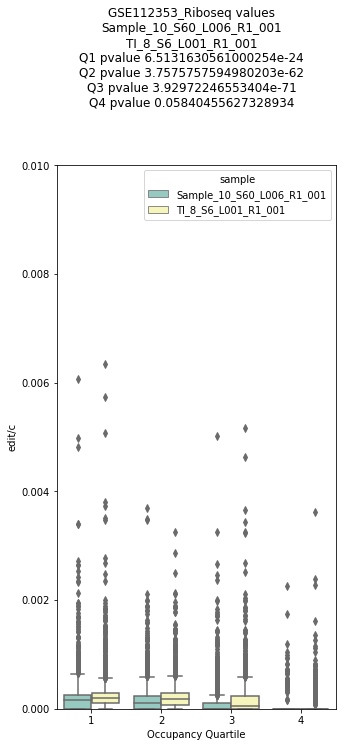

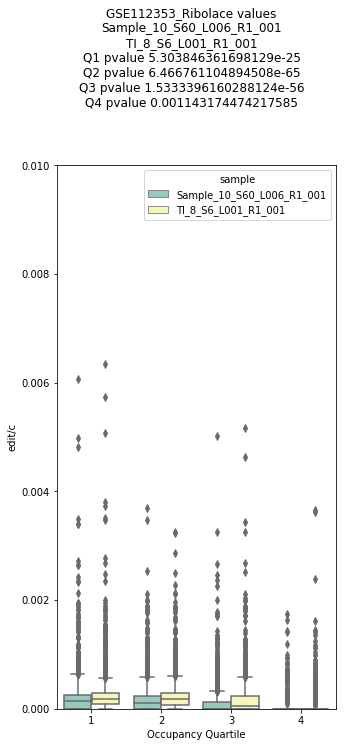

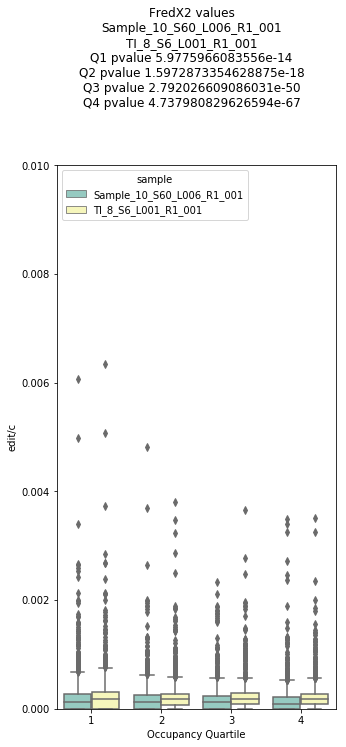

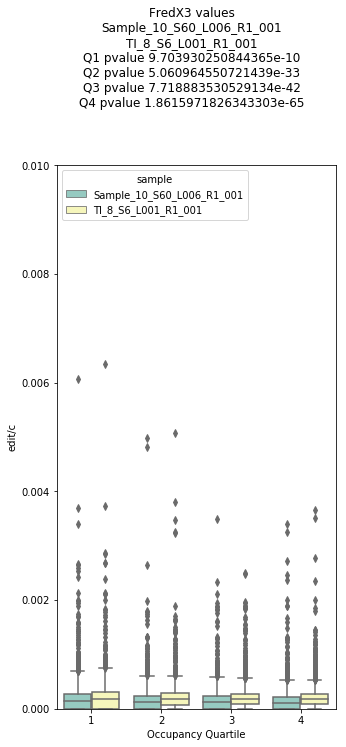

In [24]:
comparisons = [
    # ['RPS2-0_S4_L001_R1_001', 'ApoControl-0_S7_L001_R1_001'],
    # ['RPS2-50_S11_L001_R1_001', 'ApoControl-50_S14_L002_R1_001'],
    # ['RPS2-1000_S18_L002_R1_001', 'ApoControl-1000_S21_L002_R1_001'],
    # ['RPS3-1000_S19_L002_R1_001', 'ApoControl-1000_S21_L002_R1_001'],
    # ['RBFOX2-1000_S20_L002_R1_001', 'ApoControl-1000_S21_L002_R1_001'],
    # ['GSTP1-1000_S17_L002_R1_001', 'ApoControl-1000_S21_L002_R1_001'],
    # ['Sample_33_S61_L006_R1_001', 'Sample5_S26_merged'],
    # ['Sample_34_S62_L006_R1_001', 'Sample_6_S58_L006_R1_001'],
    # ['Sample19_S17_merged', 'Sample5_S26_merged'],
    # ['Sample20_S18_merged', 'Sample_6_S58_L006_R1_001'],
    # ['Sample_37_S65_L006_R1_001', 'TI_55_S13_L001_R1_001'],
    # ['Sample_38_S66_L006_R1_001', 'TI_55_S13_L001_R1_001'],
    # ['Sample_37_S65_L006_R1_001', 'TI_58_S15_L001_R1_001'],
    # ['Sample_38_S66_L006_R1_001', 'TI_59_S16_L001_R1_001'],
    # ['Sample_37_S65_L006_R1_001', 'TI_59_S16_L001_R1_001'],
    # ['TI_55_S13_L001_R1_001', 'TI_58_S15_L001_R1_001'],
    # ['TI_56_S14_L001_R1_001', 'TI_59_S16_L001_R1_001'],
    # ['Sample_37_S65_L006_R1_001.10M', 'TI_55_S13_L001_R1_001.10M'],
    # ['Sample_37_S65_L006_R1_001.10M', 'TI_56_S14_L001_R1_001'],
    # ['TI_55_S13_L001_R1_001.10M', 'TI_58_S15_L001_R1_001.10M'],
    # ['TI_56_S14_L001_R1_001', 'TI_59_S16_L001_R1_001.10M'],
    # ['Sample_38_S66_L006_R1_001.10M', 'TI_55_S13_L001_R1_001.10M'],
    # ['Sample_38_S66_L006_R1_001.10M', 'TI_56_S14_L001_R1_001'],
    # ['Sample_37_S65_L006_R1_001.10M', 'TI_58_S15_L001_R1_001.10M'],
    # ['Sample_37_S65_L006_R1_001.10M', 'TI_59_S16_L001_R1_001.10M'],
    # ['Sample_38_S66_L006_R1_001.10M', 'TI_58_S15_L001_R1_001.10M'],
    # ['Sample_38_S66_L006_R1_001.10M', 'TI_59_S16_L001_R1_001.10M'],
    # ['RPS2-T_1_S36_L003_R1_001', 'RPS2_plusT_1_S38_L003_R1_001'],
    # ['RPS2-T_2_S37_L003_R1_001', 'RPS2_plusT_2_S39_L003_R1_001'],
    # ['Apobec-T_1_S28_L003_R1_001', 'Apobec_plusT_1_S30_L003_R1_001'],
    # ['Apobec-T_2_S29_L003_R1_001', 'Apobec_plusT_2_S31_L003_R1_001'],
    # ['RPS2-STAMP_possorted_genome_bam-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt','APOBEC-STAMP_possorted_genome_bam_MD'],
    ['Sample_10_S60_L006_R1_001', 'TI_8_S6_L001_R1_001'],
]

counts = OrderedDict({
    'GSE112353_Riboseq':riboseq_hek_counts, 
    'GSE112353_Ribolace':ribolace_hek_counts, 
    'FredX2':fred_x2, 
    'FredX3':fred_x3
})      # ribosome occupancy values

for count_label, count_df in counts.items():
    count_df.to_csv(os.path.join(input_dir, '{}.txt'.format(count_label)), sep='\t')
    for comparison in comparisons:
        samp1 = comparison[0]
        samp2 = comparison[1]
        print("################ Comparing {} and {} ################".format(samp1, samp2))
        ###############################################################
        # This section parses the epsilon table and formats in a way 
        # that can easily be merged with our occupancy_counts table.
        # 
        ###############################################################
        scores2 = scores.copy(deep=True) # I want to make sure I'm not overriding values, so making a deepcopy just in case. 
        
        ### Transform Gencode-style GeneIDs to Ensembl-style. If using scRNA, Ensembl-style annotations are used already and don't have a Geneid column. Hence the try/catch.
        try:
            scores2['ensembl_Geneid'] = scores2['Geneid'].apply(lambda x: x.split('.')[0])
            del scores2['Geneid']
        except KeyError:
            pass
        
        ### Get the genes that are expressed in either dataset
        expressed_genes = set(exprs_tpm[(exprs_tpm[samp1]>0) | (exprs_tpm[samp2]>0)]['ensembl_gene_id'])
        print("We have {} expressed genes in either {} or {}".format(len(expressed_genes), samp1, samp2))
        
        scores2.set_index('ensembl_Geneid', inplace=True)
        scores2 = scores2.loc[expressed_genes]
        print("Number of genes expressed (counted): {}, number of genes with edits in any dataset: {}".format(len(expressed_genes), scores2.dropna().shape[0]))
        scores2.fillna(0, inplace=True) # if it had no edits found but is expressed, we should count these. I cannot guarantee that every expressed gene exists in our epsilon table.
        scores2.reset_index(inplace=True)
        
        ### slice scored table so it only has values associated with the 'samp' label
        scores_samp1 = scores2[['ensembl_Geneid', samp1]]
        scores_samp1.columns = ['ensembl_Geneid', 'edit/c']
        scores_samp1['sample'] = samp1
        
        scores_samp2 = scores2[['ensembl_Geneid', samp2]]
        scores_samp2.columns = ['ensembl_Geneid', 'edit/c']
        scores_samp2['sample'] = samp2
        scores_samp = pd.concat([scores_samp1, scores_samp2], axis=0)        
        
        scores_samp.set_index('ensembl_Geneid', inplace=True)
                
        ###############################################################
        # This section parses out the occupancy_counts table. We need 
        # to merge these genes with the epsilon scores from above
        # and quartile the surviving genes before box-plotting. 
        # Hopefully we don't lose too many genes in this imperfect 
        # intersection. 
        ###############################################################
        
        ### make a deepcopy of the ribo/polysome exprs so we're not accidentally modifying the original counts_df.
        occupancy_counts = count_df.copy(deep=True)
        occupancy_counts.columns = ['avg']
        
        ### Perform an 'inner join' which should intersect our epsilon table (scores_samp) with (occupancy_counts). Make sure these number make sense. 
        print("Number of genes BEFORE merging occupancy counts with scores: (scores_samp: {}, occupancy_counts: {})".format(scores_samp.shape[0]/2, occupancy_counts.shape[0]))
        scores_samp = pd.merge(occupancy_counts, scores_samp, how='inner', left_index=True, right_index=True)
        print("Number of genes AFTER merging occupancy counts with scores: (merged table: {})".format(scores_samp.shape[0]/2))
        
        ### Now, let's rank and quartile these surviving genes.
        scores_samp['pct'] = scores_samp[['avg']].rank(pct=True)
        scores_samp['Occupancy Quartile'] = scores_samp.apply(get_quartile2, axis=1)
        
        ### Compute p-values here
        pvalues = defaultdict()
        for quartile in [1, 2, 3, 4]:
            arr1 = scores_samp[(scores_samp['sample']==samp1) & (scores_samp['Occupancy Quartile']==quartile)]['edit/c']
            arr2 = scores_samp[(scores_samp['sample']==samp2) & (scores_samp['Occupancy Quartile']==quartile)]['edit/c']
            stat, pvalue = ranksums(x=arr1, y=arr2)  # Wilcoxon rank-sum
            pvalues[quartile] = pvalue
            assert arr1.shape[0] == arr2.shape[0]
            print("Number of genes in quartile {}: {}".format(quartile, arr1.shape[0]))
            ### Kris wants to look at the Q1 genes
            q_geneids = set(arr1.index)
            with open(os.path.join(output_dir, 'boxplot_q_{}_editc_{}_vs_{}.Q{}_genes.tsv'.format(
                count_label,
                samp1,
                samp2,
                quartile
            )), 'w') as o:
                for geneid in q_geneids:
                    try:
                        o.write("{}\t{}\n".format(geneid, gene_id_to_name[geneid]))
                    except KeyError:  # because we're trying to convert both ENSEMBL-style and GENCODE-style IDs.
                        o.write("{}\t{}\n".format(geneid, gene_id_to_name[geneid.split('.')[0]]))
        ### Box-plot
        fig, ax = plt.subplots(figsize=(5, 10))
        
        sns.boxplot(
            x="Occupancy Quartile", y='edit/c', hue="sample",
            data=scores_samp, palette="Set3", ax=ax, showfliers=True, 
        )
        ax.set_ylim(0, 0.01)
        fig.suptitle('{} values\n{}\n{}\nQ1 pvalue {}\nQ2 pvalue {}\nQ3 pvalue {}\nQ4 pvalue {}'.format(count_label, samp1, samp2, pvalues[1], pvalues[2], pvalues[3], pvalues[4]), y=1.1)
        fig.savefig(os.path.join(output_dir, 'boxplot_q_{}_editc_{}_vs_{}.svg'.format(count_label, samp1, samp2)))


In [25]:
scores[['RPS2-1000_S18_L002_R1_001','RPS2-T_2_S37_L003_R1_001']].corr()

,RPS2-1000_S18_L002_R1_001,RPS2-T_2_S37_L003_R1_001
RPS2-1000_S18_L002_R1_001,1.000000,0.631379
RPS2-T_2_S37_L003_R1_001,0.631379,1.000000


# Let's check a hand full of torin-resistant "IRES" genes
- These next blocks are boxplot-comparisons of a few gene sets, not relevant to all comparisons (even though I run all comps because it's easier to do). 

In [26]:
goi = [
    'ENSG00000120868.9',
    'ENSG00000107262.12',
    'ENSG00000171791.10',
    'ENSG00000248333.3',
    'ENSG00000111276.6',
    'ENSG00000009307.11',
    'ENSG00000114867.15',
    'ENSG00000110321.11',
    'ENSG00000102081.9',
    'ENSG00000100644.12',
    'ENSG00000044574.7',
    'ENSG00000070444.10',
    'ENSG00000136997.10',
    'ENSG00000186416.8',
    'ENSG00000102317.13',
    'ENSG00000159216.14',
    'ENSG00000139514.8',
    'ENSG00000141510.11',
    'ENSG00000112715.16',
    'ENSG00000101966.8'
]

In [27]:
scores['gene_type'] = scores.apply(get_gene_is_pc, axis=1)
scores.head()

,Geneid,ABCE1-0_S1_L001_R1_001,ABCE1-1000_S15_L002_R1_001,ABCE1-50_S8_L001_R1_001,APOBEC_only_0_merged_R1,APOBEC_only_1000_merged_R1,APOBEC_only_50_merged_R1,ApoControl-0_S7_L001_R1_001,ApoControl-1000_S21_L002_R1_001,ApoControl-1000_S21_L002_R1_001.21M,...,TI_5_S4_L001_R1_001,TI_7_S5_L001_R1_001,TI_8_S6_L001_R1_001,Tia1_0ng_1_S40_L003_R1_001,Tia1_0ng_2_S41_L003_R1_001,Tia1_1000ng_1_S14_L001_R1_001,Tia1_1000ng_2_S27_L002_R1_001,Tia1_50ng_1_S42_L003_R1_001,Tia1_50ng_2_S13_L001_R1_001,gene_type
0,ENSG00000000003.10,0.000105,0.000708,0.000279,0.000000,0.000467,0.000329,0.000090,0.000859,0.001102,...,0.000105,0.000656,0.000239,0.000219,0.000272,0.002802,0.000692,0.000798,0.000392,protein_coding
1,ENSG00000000419.8,0.000000,0.000408,0.000000,0.000351,0.000840,0.000000,0.000203,0.000662,0.000638,...,0.000000,0.000577,0.000000,0.000000,0.000271,0.001170,0.002818,0.000543,0.000572,protein_coding
2,ENSG00000000457.9,0.000000,0.000000,0.000000,0.000313,0.000000,0.000000,0.000216,0.000000,0.000000,...,0.000324,0.000000,0.000138,0.000126,0.000000,0.000286,0.000747,0.000000,0.000728,protein_coding
3,ENSG00000000460.12,0.000000,0.000145,0.000000,0.000160,0.000165,0.000213,0.000234,0.000556,0.000541,...,0.000431,0.000468,0.000279,0.000269,0.000089,0.000861,0.000954,0.000371,0.000094,protein_coding
4,ENSG00000001036.9,0.000139,0.000547,0.000432,0.000185,0.000451,0.000493,0.000261,0.000743,0.000871,...,0.000100,0.000624,0.000346,0.000078,0.000279,0.000675,0.000405,0.000096,0.000000,protein_coding


/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


p-value: 0.5427717015170068


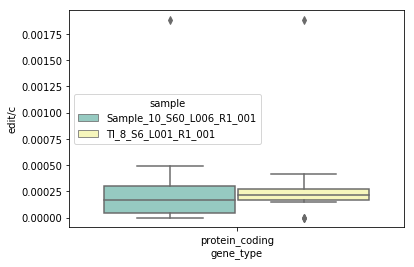

In [28]:
for comparison in comparisons:
    samp1 = comparison[0]
    samp2 = comparison[1]
    # slice scored table so it only has values associated with the 'samp' label
    scores_samp1 = scores[['Geneid', samp1, 'gene_type']]
    scores_samp1.columns = ['Geneid', 'edit/c', 'gene_type']
    scores_samp1['sample'] = samp1

    scores_samp2 = scores[['Geneid', samp2, 'gene_type']]
    scores_samp2.columns = ['Geneid', 'edit/c', 'gene_type']
    scores_samp2['sample'] = samp2

    scores_samp = pd.concat([scores_samp1, scores_samp2], axis=0)        
    # only protein coding genes for scores table
    scores_samp = scores_samp[scores_samp['gene_type']=='protein_coding']
    scores_samp = scores_samp[scores_samp['Geneid'].isin(goi)]
    
    fig, ax = plt.subplots()
    sns.boxplot(
        x='gene_type', y='edit/c', hue="sample",
        data=scores_samp, palette="Set3", ax=ax, showfliers=True
    )
    arr1 = list(scores_samp[(scores_samp['sample']==samp1)]['edit/c'])
    arr2 = list(scores_samp[(scores_samp['sample']==samp2)]['edit/c'])
    
    stat, pvalue = ranksums(x=arr1, y=arr2)  # Wilcoxon rank-sum
    print("p-value: {}".format(pvalue))

# Let's compare samples against TOP genes

In [29]:
TOP_genes = pd.read_csv(os.path.join(input_dir, 'TOP_genes.txt'), sep='\t', names=['geneid','genename'])
TOP_genes.head()

,geneid,genename
0,ENSG00000156508.13,EEF1A1
1,ENSG00000114942.9,EEF1B2
2,ENSG00000104529.13,EEF1D
3,ENSG00000124802.7,EEF1E1
4,ENSG00000254772.5,EEF1G


/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


Comparing 13330.0 -> 63.0 genes. p-value: 0.9338942211145608


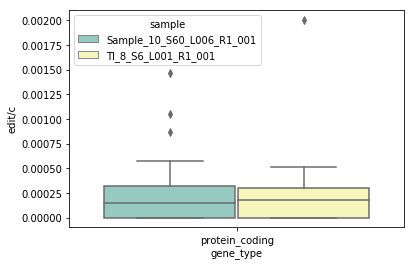

In [30]:
for comparison in comparisons:
    samp1 = comparison[0]
    samp2 = comparison[1]
    # slice scored table so it only has values associated with the 'samp' label
    scores_samp1 = scores[['Geneid', samp1, 'gene_type']]
    scores_samp1.columns = ['Geneid', 'edit/c', 'gene_type']
    scores_samp1['sample'] = samp1

    scores_samp2 = scores[['Geneid', samp2, 'gene_type']]
    scores_samp2.columns = ['Geneid', 'edit/c', 'gene_type']
    scores_samp2['sample'] = samp2

    scores_samp = pd.concat([scores_samp1, scores_samp2], axis=0)
    # only protein coding genes for scores table
    scores_samp = scores_samp[scores_samp['gene_type']=='protein_coding']
    npc_genes = scores_samp.shape[0]/2
    scores_samp = scores_samp[scores_samp['Geneid'].isin(TOP_genes['geneid'])]
    ntop_genes = scores_samp.shape[0]/2
    fig, ax = plt.subplots()
    sns.boxplot(
        x='gene_type', y='edit/c', hue="sample",
        data=scores_samp, palette="Set3", ax=ax, showfliers=True
    )
    arr1 = list(scores_samp[(scores_samp['sample']==samp1)]['edit/c'])
    arr2 = list(scores_samp[(scores_samp['sample']==samp2)]['edit/c'])
    
    stat, pvalue = ranksums(x=arr1, y=arr2)  # Wilcoxon rank-sum
    print("Comparing {} -> {} genes. p-value: {}".format(npc_genes, ntop_genes, pvalue))